# Distributed Training with LightningLite, SageMaker, and Flair

## Getting started
- [Getting Started with Tensor Parallelism using the SageMaker Model Parallelism Library
](https://github.com/aws/amazon-sagemaker-examples/blob/main/training/distributed_training/pytorch/model_parallel/gpt-j/11_train_gptj_smp_tensor_parallel_notebook.ipynb)
- [LightningLite Integration with Flair](https://github.com/flairNLP/flair/pull/2700)
- [LIGHTNINGLITE - STEPPING STONE TO LIGHTNING](https://pytorch-lightning.readthedocs.io/en/stable/starter/lightning_lite.html)

## Launch training locally
- [PYTORCH_LIGHTNING.LITE.LIGHTNINGLITE](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.lite.LightningLite.html#pytorch_lightning.lite.LightningLite)

### Original (single-instance single-gpu)

In [ ]:
# !python code/original/run_ner.py \
#     --dataset_name NER_ENGLISH_PERSON \
#     --model_name_or_path xlm-roberta-base \
#     --batch_size 32 \
#     --learning_rate 5e-05 \
#     --num_epochs 50 \
#     --context_size 64 \
#     --output_dir ner-english-test

### Custom training (single-instance multi-gpu)

In [ ]:
!python custom_run_ner.py \
    --dataset_name NER_ENGLISH_PERSON \
    --model_name_or_path xlm-roberta-base \
    --batch_size 32 \
    --learning_rate 5e-05 \
    --embeddings_storage_mode gpu \
    --num_epochs 2 \
    --context_size 64 \
    --accelerator gpu \
    --strategy ddp \
    --devices 4 \
    --num_nodes 1 \
    --precision 16 \
    --output_dir ner-english-test

2022-05-24 17:01:10,436 Reading data from /home/ec2-user/.flair/datasets/ner_english_person
2022-05-24 17:01:10,436 Train: /home/ec2-user/.flair/datasets/ner_english_person/bigFile.conll
2022-05-24 17:01:10,436 Dev: None
2022-05-24 17:01:10,436 Test: None
2022-05-24 17:01:15,657 Corpus: 28362 train + 3151 dev + 3501 test sentences
2022-05-24 17:01:15,657 Computing label dictionary. Progress:
28362it [00:00, 74961.01it/s]
2022-05-24 17:01:16,036 Dictionary created for label 'ner' with 4 values: M (seen 28093 times), F (seen 4520 times), A (seen 597 times)
2022-05-24 17:01:16,036 Dictionary with 4 tags: <unk>, M, F, A
2022-05-24 17:01:27,136 SequenceTagger predicts: Dictionary with 4 tags: <unk>, M, F, A
Using 16bit native Automatic Mixed Precision (AMP)
2022-05-24 17:01:29,067 Reading data from /home/ec2-user/.flair/datasets/ner_english_person
2022-05-24 17:01:29,067 Train: /home/ec2-user/.flair/datasets/ner_english_person/bigFile.conll
2022-05-24 17:01:29,067 Dev: None
2022-05-24 17:01

## Launch training remotely using SageMaker Training Jobs

### Permissions

In [6]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::110564771975:role/service-role/AmazonSageMaker-ExecutionRole-20210806T162946
sagemaker bucket: sagemaker-eu-west-2-110564771975
sagemaker session region: eu-west-2


### Creating an Estimator and start a training job with `custom_run_ner.py`

In [30]:
from sagemaker.huggingface import HuggingFace

In [45]:
# hyperparameters, which are passed into the training job
hyperparameters={
    'dataset_name': 'NER_ENGLISH_PERSON',
    'model_name_or_path': "xlm-roberta-base",
    'batch_size': 32,
    'learning_rate': 5e-05,
    'embeddings_storage_mode': 'gpu',
    'accelerator': 'gpu',
    'strategy': 'ddp',
#     'devices': 4,
    'num_nodes': 1,
    'precision': 16,
    'num_epochs': 2,
    'context_size': 64,
    'output_dir': '/opt/ml/model',
}

# configuration for running training on smdistributed Data Parallel
# distribution = {'smdistributed':{'dataparallel':{ 'enabled': True }}}

# instance configurations
instance_type='ml.p3.8xlarge'
# instance_type='ml.g4dn.12xlarge'
instance_count=1
volume_size=100

# metric definition to extract the results
metric_definitions=[
    {'Name': 'epoch', 'Regex': "epoch.*=\D*(.*?)$"},
    {'Name': 'loss', 'Regex': "loss.*=\D*(.*?)$"},
    {'Name': 'f1', 'Regex': "f1.*=\D*(.*?)$"},
    {'Name': 'precision', 'Regex': "precision.*=\D*(.*?)$"},
    {'Name': 'recall', 'Regex': "recall.*=\D*(.*?)$"}]

In [46]:
# estimator
huggingface_estimator = HuggingFace(entry_point='custom_run_ner.py',
                                    source_dir='.',
                                    metric_definitions=metric_definitions,
                                    instance_type=instance_type,
                                    instance_count=instance_count,
                                    volume_size=volume_size,
                                    role=role,
                                    transformers_version='4.17.0',
                                    pytorch_version='1.10.2',
                                    py_version='py38',
#                                     distribution= distribution,
                                    hyperparameters = hyperparameters)

In [47]:
# starting the train job
huggingface_estimator.fit(wait=False)

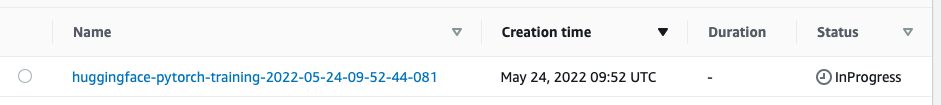

### Creating an Estimator and start a training job with `run_ner.py`

In [27]:
# hyperparameters, which are passed into the training job
hyperparameters={
    'dataset_name': 'NER_ENGLISH_PERSON',
    'model_name_or_path': "xlm-roberta-base",
    'batch_size': 32,
    'learning_rate': 5e-05,
    'embeddings_storage_mode': 'gpu',
    'num_epochs': 2,
    'context_size': 64,
    'output_dir': 'ner-english-test',
}

# configuration for running training on smdistributed Data Parallel
# distribution = {'smdistributed':{'dataparallel':{ 'enabled': True }}}

# instance configurations
instance_type='ml.p3.8xlarge'
# instance_type='ml.g4dn.12xlarge'
instance_count=1
volume_size=100

# metric definition to extract the results
metric_definitions=[
    {'Name': 'epoch', 'Regex': "epoch.*=\D*(.*?)$"},
    {'Name': 'loss', 'Regex': "loss.*=\D*(.*?)$"},
    {'Name': 'f1', 'Regex': "f1.*=\D*(.*?)$"},
    {'Name': 'precision', 'Regex': "precision.*=\D*(.*?)$"},
    {'Name': 'recall', 'Regex': "recall.*=\D*(.*?)$"}]

In [28]:
# estimator
huggingface_estimator = HuggingFace(entry_point='run_ner.py',
                                    source_dir='.',
                                    metric_definitions=metric_definitions,
                                    instance_type=instance_type,
                                    instance_count=instance_count,
                                    volume_size=volume_size,
                                    role=role,
                                    transformers_version='4.17.0',
                                    pytorch_version='1.10.2',
                                    py_version='py38',
#                                     distribution= distribution,
                                    hyperparameters = hyperparameters)

In [29]:
# starting the train job
huggingface_estimator.fit(wait=False)